# Personality Determinant Using Random Forest

In [96]:
#Import required libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [3]:
def wrangle(filepath):
    df = pd.read_csv(filepath)

    return df

In [4]:
# Load data
df = wrangle(r"C:\Users\User\Desktop\compiler\Personality\train.csv")

In [5]:
# To sho the first five columns of the data
df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [6]:
# To show the shape of the data
print(f"Data shape: {df.shape}")
print(f"\n {df.info()}")

Data shape: (18524, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB

 None


In [7]:
# To calculate the percentage of missing values
print(f"Missing Values:\n {df.isnull().sum()}")
print(f"Percentage of missing values:\n{df.isnull().sum() / len(df)* 100}")

Missing Values:
 id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64
Percentage of missing values:
id                            0.000000
Time_spent_Alone              6.424098
Stage_fear                   10.219175
Social_event_attendance       6.370114
Going_outside                 7.914057
Drained_after_socializing     6.202764
Friends_circle_size           5.689916
Post_frequency                6.823580
Personality                   0.000000
dtype: float64


In [8]:
df.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [9]:
# Multi colinearlity check
df["Social_event_attendance"].nunique()

11

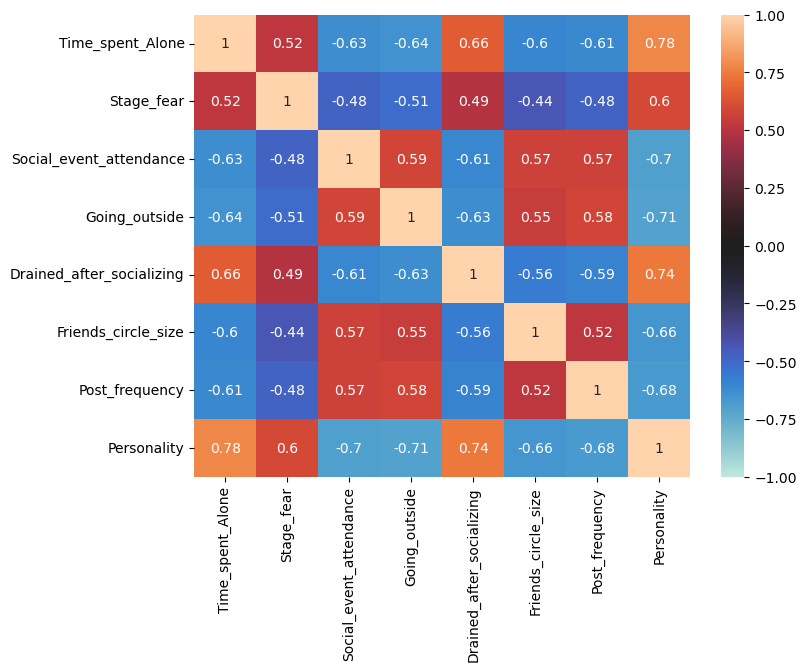

In [28]:
# To visualize relationship between features  and target through a heatmap
features = ["Time_spent_Alone",	"Stage_fear", "Social_event_attendance", "Going_outside", "Drained_after_socializing", "Friends_circle_size", "Post_frequency","Personality"]
corr_data = df[features].copy()

# To create instances of label encoder for each categorical feature
label_fear = LabelEncoder() 
label_social = LabelEncoder()
label_per = LabelEncoder()

# Encode categorical data using label encoder
corr_data["Stage_fear"] = label_fear.fit_transform(corr_data["Stage_fear"])
corr_data["Drained_after_socializing"] = label_social.fit_transform(corr_data["Drained_after_socializing"])
corr_data["Personality"] = label_per.fit_transform(corr_data["Personality"])

# To generate correlation matrix
corr = corr_data.corr()

# Heatmap plot
plt.figure(figsize = (8, 6))
sns.heatmap(corr, annot = True, vmin=-1, vmax= 1, center = 0);


In [81]:
# Data preprocessing
def preprocesssing(df):
    # To maintain the original data
    df_process = df.copy()
    # Sepparate numerical, categorical and boolean values for imputation
    num_cols = df_process.select_dtypes(include = [np.number]).columns
    cat_cols = df_process.select_dtypes(exclude = [np.number]).columns
    bool_cols = [col for col in df_process.columns if 
                 df_process[col].dropna().isin(["Yes", "No"]).all() or 
                 df_process[col].dtype == bool] 
    

    # Impute missing numerical values with mean
    for column in num_cols:
        df_process[column].fillna(df_process[column].mean(), inplace = True)
    # Impute missing categorical values with mode
    for column in cat_cols:
        df_process[column].fillna(df_process[column].mode([0]), inplace = True)
                                 
    # Impute boolean values with mode based on personality
    for column in bool_cols:
        # Calculate the mode for each personality category
        mode_by_personality = df_process.groupby("Personality")[column].agg(lambda x: x.mode()[0] if not x.mode().empty else "No")
        # imputation based o personality
        df_process[column] = df.apply(
            lambda row: mode_by_personality[row["Personality"]] if pd.isna(row[column]) else row[column],
            axis = 1            
        )

    # Encode categorical columns
    cat_cols = ["Stage_fear", "Drained_after_socializing", "Personality"]
    df_process = pd.get_dummies(df_process, columns = cat_cols, drop_first = True)

    # Convert bool to int
    for col in df_process.columns:
        if df_process[col].dtype == "bool":
            df_process[col] = df_process[col].astype(int)

    # Staandadize numerical columns
    numerical_cols = ["Time_spent_Alone", "Social_event_attendance","Going_outside", "Friends_circle_size",	"Post_frequency"]
    scaler = StandardScaler()
    df_process[numerical_cols] = scaler.fit_transform(df_process[numerical_cols])
    
    
    return df_process

In [82]:
df_clean = preprocesssing(df)
df_clean.head()

C:\Users\User\AppData\Local\Temp\ipykernel_13620\4024783129.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_process[column].fillna(df_process[column].mean(), inplace = True)
C:\Users\User\AppData\Local\Temp\ipykernel_13620\4024783129.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,Stage_fear_Yes,Drained_after_socializing_Yes,Personality_Introvert
0,0,-1.079896,0.275846,-0.022392,1.707509,0.006442,0,0,0
1,1,-0.735735,0.651201,-0.527641,0.488428,1.085931,0,0,0
2,2,0.985070,-1.600930,-2.043388,-1.218285,-1.792706,1,1,1
3,3,-0.047413,0.651201,-0.527641,0.732244,0.006442,0,0,0
4,4,-0.735735,-0.474864,-0.022392,1.219876,0.000000,0,0,0


In [89]:
# To sepate data into feature and target
features = (col for col in df_clean.columns if col not in ["Personality_Introvert", "id"])
X = df_clean[features]
y = df_clean["Personality_Introvert"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [92]:
X.head()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,Stage_fear_Yes,Drained_after_socializing_Yes
0,-1.079896,0.275846,-0.022392,1.707509,0.006442,0,0
1,-0.735735,0.651201,-0.527641,0.488428,1.085931,0,0
2,0.985070,-1.600930,-2.043388,-1.218285,-1.792706,1,1
3,-0.047413,0.651201,-0.527641,0.732244,0.006442,0,0
4,-0.735735,-0.474864,-0.022392,1.219876,0.000000,0,0


In [95]:
# Train data with random forest model
rf_model = RandomForestClassifier(random_state = 42)
param_grid = {
    "n_estimators" :[50, 100, 200],
    "max_depth": [None, 10, 20]
}

grid_search = GridSearchCV(rf_model, param_grid, cv = 5, scoring = "accuracy")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [98]:
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")


Model accuracy: 0.970310391363023
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2753
           1       0.96      0.93      0.94       952

    accuracy                           0.97      3705
   macro avg       0.97      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



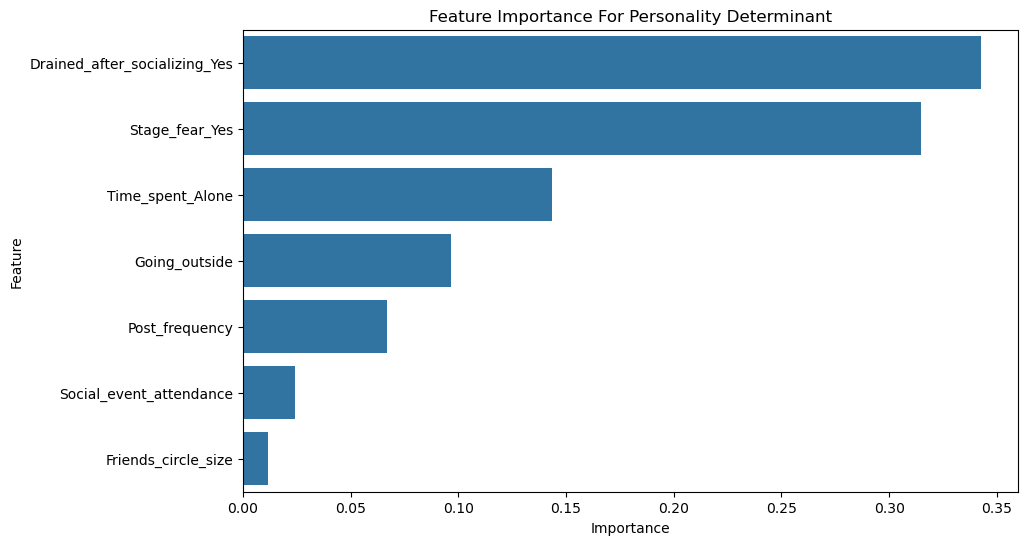

In [102]:
# To Visualize feature byimportance 
importance = best_rf_model.feature_importances_
features = X.columns

# To create a dataFrame of te feature and importance
feature_importance_df = pd.DataFrame({
    "Feature" : features,
    "Importance" : importance
}
)
feature_importance_df = feature_importance_df.sort_values("Importance", ascending = False)

plt.figure(figsize = (10, 6))
sns.barplot(x = "Importance", y = "Feature", data = feature_importance_df)
plt.title("Feature Importance For Personality Determinant");
